# Image Retrieval using Embeddings and a Nearest Neighbour search (Edge Map improvement)

## Imports

In [1]:
%pip install numpy torch torchvision matplotlib tqdm pillow scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from scipy.signal import gaussian
from sklearn.manifold import TSNE
from operator import itemgetter
from PIL import Image

## Dataset

### Utils

In [3]:
mean = torch.tensor([0.0812, 0.0764, 0.0727])
std = torch.tensor([0.1789, 0.1699, 0.1633])

batch_size = 128

def get_image_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=batch_size)
    numberof_images = 0
    mean, std = 0, 0

    for batch, _, _ in tqdm.tqdm(loader, unit="batch"):
        batch = batch.view(batch.size(0), batch.size(1), -1)

        numberof_images += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    return mean / numberof_images, std / numberof_images

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize=False):
    x = unnormalize(x)
    
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    
    return x

def show(image, axis=None):
    numpy_image = image.cpu().numpy()
    if axis is not None:
        axis.imshow(np.transpose(numpy_image, (1,2,0)))
    else:
        plt.imshow(np.transpose(numpy_image, (1,2,0)))

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std)                   
])

class ImageFolderWithImagePath(datasets.ImageFolder):
    def __getitem__(self, index):
        data = super().__getitem__(index)
        path = self.imgs[index][0]

        return *data, path

### Load ShapeNet (smaller version for this task)

In [4]:
shapenet_dataset = ImageFolderWithImagePath("ShapeNetReduced/", transform=transform)

In [5]:
mean, std = get_image_mean_and_std(shapenet_dataset)
print(f"Mean: {mean}\nStd. Deviation: {std}")

100%|██████████| 251/251 [00:36<00:00,  6.84batch/s]

Mean: tensor([0.0812, 0.0764, 0.0727])
Std. Deviation: tensor([0.1835, 0.1744, 0.1677])


### Reducing Dataset Size (testing)

In [6]:
shapenet_size = len(shapenet_dataset)
print(f"Size of ShapeNet: {shapenet_size} images.")

shapenet_reduced_size = shapenet_size // 1
unused_shapenet_size = shapenet_size - shapenet_reduced_size
shapenet_reduced_dataset, _ = random_split(shapenet_dataset, (shapenet_reduced_size, unused_shapenet_size))

print(f"Size of reduced ShapeNet: {len(shapenet_reduced_dataset)} images.")

Size of ShapeNet: 32040 images.
Size of reduced ShapeNet: 32040 images.


### Shuffling and Splitting Dataset

In [7]:
ratios = (0.7, 0.1, 0.01, 0.19)

sizes = list(map(lambda x: round(len(shapenet_reduced_dataset) * x), ratios))
if sum(sizes) < len(shapenet_reduced_dataset):
      sizes[0] += len(shapenet_reduced_dataset) - sum(sizes)

print(f"Dataset sizes: {tuple(sizes)}")

[train, test, query, db] = random_split(shapenet_reduced_dataset, sizes)

print(f"Dataset Lengths:"
      f"\n\tTrain: {len(train)},"
      f"\n\tTest: {len(test)},"
      f"\n\tQuery: {len(query)},"
      f"\n\tDatabase: {len(db)}")

loader_train = DataLoader(train, batch_size=batch_size)
loader_test = DataLoader(test, batch_size=batch_size, shuffle=False)
loader_query = DataLoader(query, batch_size=batch_size)
loader_database = DataLoader(db, batch_size=batch_size)

Dataset sizes: (22428, 3204, 320, 6088)
Dataset Lengths:
	Train: 22428,
	Test: 3204,
	Query: 320,
	Database: 6088


## Model

In [8]:
class AutoEncoderModel(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.latent_size = latent_size
        self.fc_size = 1024

        self.encoder = nn.Sequential(
            # Input is 128 x 128 x 3, Output is 1 x 1 x 1024
            nn.Conv2d(in_channels=1, out_channels=64, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 32 x 32 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 16 x 16 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 8 x 8 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=self.fc_size,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 4 x 4 x 1024
            nn.BatchNorm2d(self.fc_size),
            nn.AvgPool2d(4), # 1 x 1 x 1024
            nn.ReLU(inplace=True)
        )
        
        self.encoder_mu = nn.Linear(in_features=self.fc_size, 
                                    out_features=self.latent_size)

        self.encoder_var = nn.Linear(in_features=self.fc_size,
                                     out_features=self.latent_size)

        self.decoder_fc = nn.Linear(in_features=self.latent_size, 
                                    out_features=self.fc_size)

        self.decoder = nn.Sequential(
            # Input is 1 x 1 x 1024, Output is 64 x 64 x 3
            nn.ConvTranspose2d(in_channels=self.fc_size,
                               out_channels=self.fc_size,
                               kernel_size=4), # 4 x 4 x 1024
            nn.BatchNorm2d(self.fc_size),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=self.fc_size,
                               out_channels=512,
                               kernel_size=4, padding=1,
                               stride=2), # 8 x 8 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256,
                               kernel_size=4, padding=1,
                               stride=2), # 16 x 16 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4, padding=1,
                               stride=2), # 32 x 32 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4, padding=1,
                               stride=2), # 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=1,
                               kernel_size=4, padding=1,
                               stride=2), # 128 x 128 x 3
            nn.Sigmoid()
        )

        initial_scale = torch.tensor([1], dtype=torch.float, device=device)
        self.scale = nn.Parameter(initial_scale, requires_grad=True)
        
        self.register_parameter(name="scale", param=self.scale)
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        mean = self.encoder_mu(x)
        logvar = self.encoder_var(x)

        return mean, logvar
    
    def reparametrize(self, mu, logvar):
        return mu + torch.rand_like(mu).mul(torch.exp(logvar / 2))

    def decode(self, z):
        z = self.decoder_fc(z)
        z = z.view(z.size(0), self.fc_size, 1, 1)
        
        return self.decoder(z)# * self.scale
    
    def forward(self, x):
        mu, logvar = self.encode(x)

        z = mu if not self.training \
            else self.reparametrize(mu, logvar)

        reconstruction = self.decode(z)
        return reconstruction, mu, logvar


### Canny Edge Detector with NMS
copied from [DCurro/CannyEdgePyTorch](https://github.com/DCurro/CannyEdgePytorch)

In [17]:
class Canny(nn.Module):
	def __init__(self, threshold=10.0, device="cpu"):
		super().__init__()

		self.threshold = threshold
		self.device = device

		filter_size = 5

		gaussian_filter = gaussian(filter_size, std=1.0).reshape([1,filter_size])
		gaussian_filter = torch.from_numpy(gaussian_filter).to(device)

		self.gaussian_horizontal = nn.Conv2d(in_channels=1, out_channels=1,
											 kernel_size=(1, filter_size),
											 padding=(0, filter_size//2),
											 bias=False)

		self.gaussian_horizontal.weight.data.copy_(gaussian_filter)

		self.gaussian_vertical = nn.Conv2d(in_channels=1, out_channels=1,
										   kernel_size=(filter_size, 1),
										   padding=(filter_size//2, 0),
										   bias=False)

		self.gaussian_vertical.weight.data.copy_(gaussian_filter.t())

		sobel_filter = torch.tensor([
			[1, 0, -1],
			[2, 0, -2],
			[1, 0, -1]
		]).to(device)

		self.sobel_horizontal = nn.Conv2d(in_channels=1, out_channels=1,
										  kernel_size=sobel_filter.shape,
										  padding=sobel_filter.shape[0]//2,
										  bias=False)

		self.sobel_horizontal.weight.data.copy_(sobel_filter)

		self.sobel_vertical = nn.Conv2d(in_channels=1, out_channels=1,
										kernel_size=sobel_filter.shape, 
										padding=sobel_filter.shape[0]//2,
										bias=False)

		self.sobel_vertical.weight.data.copy_(sobel_filter.t())

		# filters were flipped manually
		filter_0 = np.array([
			[ 0, 0, 0],
			[ 0, 1, -1],
			[ 0, 0, 0]
		])

		filter_45 = np.array([
			[0, 0, 0],
			[ 0, 1, 0],
			[ 0, 0, -1]
		])

		filter_90 = np.array([
			[ 0, 0, 0],
			[ 0, 1, 0],
			[ 0,-1, 0]
		])

		filter_135 = np.array([
			[ 0, 0, 0],
			[ 0, 1, 0],
			[-1, 0, 0]
		])

		filter_180 = np.array([
			[ 0, 0, 0],
			[-1, 1, 0],
			[ 0, 0, 0]
		])

		filter_225 = np.array([
			[-1, 0, 0],
			[ 0, 1, 0],
			[ 0, 0, 0]
		])

		filter_270 = np.array([
			[ 0,-1, 0],
			[ 0, 1, 0],
			[ 0, 0, 0]
		])

		filter_315 = np.array([
			[ 0, 0, -1],
			[ 0, 1, 0],
			[ 0, 0, 0]
		])

		all_filters = np.stack([
			filter_0, filter_45, filter_90, 
			filter_135, filter_180, filter_225, 
			filter_270, filter_315
		])

		all_filters = torch.from_numpy(all_filters).to(device)

		self.directional_filter = nn.Conv2d(in_channels=1, out_channels=8,
											kernel_size=filter_0.shape,
											padding=filter_0.shape[-1] // 2,
											bias=False)

		self.directional_filter.weight.data.copy_(all_filters[:, None, ...])

	def forward(self, img):
		image_r = img[:, 0:1]
		image_g = img[:, 1:2]
		image_b = img[:, 2:3]

		blur_horizontal = self.gaussian_horizontal(image_r)
		blurred_r = self.gaussian_vertical(blur_horizontal)
		blur_horizontal = self.gaussian_horizontal(image_g)
		blurred_g = self.gaussian_vertical(blur_horizontal)
		blur_horizontal = self.gaussian_horizontal(image_b)
		blurred_b = self.gaussian_vertical(blur_horizontal)

		blurred_img = torch.stack([blurred_r, blurred_g, blurred_b], dim=1)
		#blurred_img = torch.stack([torch.squeeze(blurred_img)])

		grad_x_r = self.sobel_horizontal(blurred_r)
		grad_y_r = self.sobel_vertical(blurred_r)
		grad_x_g = self.sobel_horizontal(blurred_g)
		grad_y_g = self.sobel_vertical(blurred_g)
		grad_x_b = self.sobel_horizontal(blurred_b)
		grad_y_b = self.sobel_vertical(blurred_b)

		# COMPUTE THICK EDGES

		grad_mag = torch.sqrt(grad_x_r**2 + grad_y_r**2)
		grad_mag += torch.sqrt(grad_x_g**2 + grad_y_g**2)
		grad_mag += torch.sqrt(grad_x_b**2 + grad_y_b**2)
		grad_orientation = (torch.atan2(grad_y_r+grad_y_g+grad_y_b, grad_x_r+grad_x_g+grad_x_b) * (180.0/3.14159))
		grad_orientation += 180.0
		grad_orientation =  torch.round(grad_orientation / 45.0) * 45.0

		# THIN EDGES (NON-MAX SUPPRESSION)

		all_filtered = self.directional_filter(grad_mag)

		inidices_positive = (grad_orientation / 45) % 8
		inidices_negative = ((grad_orientation / 45) + 4) % 8

		batch_size = inidices_positive.size()[0]

		height = inidices_positive.size()[2]
		width = inidices_positive.size()[3]
		pixel_count = height * width

		pixel_range = torch.FloatTensor([range(pixel_count)]).to(self.device)
		
		indices = (inidices_positive.view(batch_size, -1).data * pixel_count + pixel_range).view(-1)
		channel_select_filtered_positive = all_filtered.view(-1)[indices.long()].view(batch_size, 1, height, width)
		channel_select_filtered_positive = channel_select_filtered_positive.view(batch_size, 1, height, width)
		
		indices = (inidices_negative.view(batch_size, -1).data * pixel_count + pixel_range).view(-1)
		channel_select_filtered_negative = all_filtered.view(-1)[indices.long()].view(batch_size, 1, height, width)

		channel_select_filtered = torch.stack([channel_select_filtered_positive,channel_select_filtered_negative], dim=1)

		is_max = channel_select_filtered.min(dim=1)[0] > 0.0

		thin_edges = grad_mag.clone()
		thin_edges[is_max==0] = 0.0

		# THRESHOLD

		thresholded = thin_edges.clone()
		thresholded[thin_edges < self.threshold] = 0.0

		early_threshold = grad_mag.clone()
		early_threshold[grad_mag < self.threshold] = 0.0

		assert grad_mag.size() == grad_orientation.size() == thin_edges.size() == thresholded.size() == early_threshold.size()

		return F.sigmoid(early_threshold)
		#return blurred_img, grad_mag, grad_orientation, thin_edges, thresholded, early_threshold

In [37]:
canny = Canny(threshold, device).to(device)

canny.eval()

Canny(
  (gaussian_horizontal): Conv2d(1, 1, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
  (gaussian_vertical): Conv2d(1, 1, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), bias=False)
  (sobel_horizontal): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sobel_vertical): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (directional_filter): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

## Search Algorithm

In [39]:
def cosine_similarity(a: np.ndarray, b: np.ndarray):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def similarity_metric(target, embedding):
    vector, path = embedding
    return cosine_similarity(target, vector), path

def get_closest_match(target_image, embeddings):
    target_image_edges = canny(target_image.to(device).unsqueeze(0))
    mean, _ = model.encode(target_image_edges)
    target_embedding = mean.squeeze(0).cpu().detach().numpy()
    
    similarity = map(lambda x: similarity_metric(target_embedding, x), embeddings)
    return sorted(similarity, key=itemgetter(0), reverse=True)

## Training

### Enable CUDA

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### Hyperparameters

In [20]:
num_epochs = 20
learning_rate = 5e-4
batch_size = 128
beta = 0.3
image_size = 64
weight_decay = 1e-9
latent_size = 100

# Edge Detector
threshold = 8.0
use_cuda = torch.cuda.is_available()

### Loss Function

In [21]:
def vae_loss(recon_x, x, mu, logvar, beta):
	x_reshaped = x.view(-1, image_size ** 2)
	recon_x_reshaped = recon_x.view(-1, image_size ** 2)

	loss = F.binary_cross_entropy(recon_x_reshaped, x_reshaped, reduction="sum")
	divergence = torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / 2

	return loss - (beta * divergence)

### Initialisation

In [22]:
model = AutoEncoderModel(latent_size).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay)

### Sample Data

#### Without Edge Detection

Dimensions of a batch: torch.Size([128, 3, 128, 128])


/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


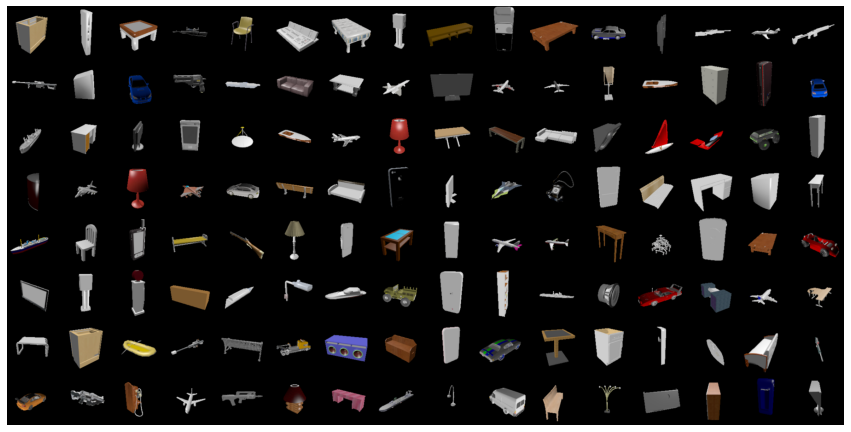

In [23]:
samples, _, _ = next(iter(loader_test))

print(f"Dimensions of a batch: {samples.shape}")

samples = samples.cpu()
samples = make_grid(samples, nrow=16, padding=0, normalize=False,
                    range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(samples)

#### With Edge Detection

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Dimensions of a batch: torch.Size([128, 1, 128, 128])


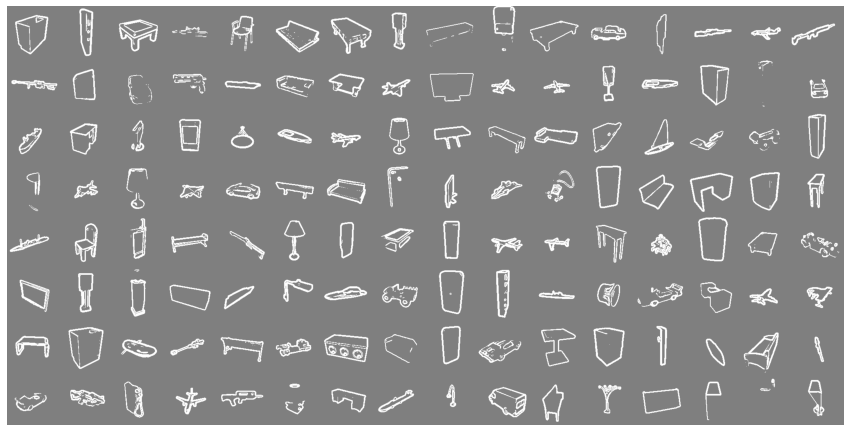

In [24]:
samples, _, _ = next(iter(loader_test))
samples = canny(samples.to(device)).cpu()

print(f"Dimensions of a batch: {samples.shape}")

samples = make_grid(samples, nrow=16, padding=0, normalize=False,
                    range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(samples)

### Training Loop

In [25]:
report_every = 20
epoch_losses = list()

model.train()

for epoch in range(num_epochs):
	epoch_loss = 0
	num_batches = 0

	with tqdm.tqdm(loader_train, unit="batch") as tepoch:
		tepoch.set_description(f"Epoch {epoch+1}")

		for i, (images, _, _) in enumerate(tepoch):   
			optimiser.zero_grad()
			images = images.to(device)
			
			with torch.no_grad():
				edge_maps = canny(images)

			reconstruction, mu, logvar = model(edge_maps)
			loss = vae_loss(reconstruction, edge_maps, mu, logvar, beta)

			loss.backward()
			optimiser.step()

			epoch_loss += loss.item()
			num_batches += 1

			training_loss = loss.item() / len(images)
			tepoch.set_postfix(loss=training_loss)

	epoch_losses.append(epoch_loss / num_batches)

Epoch 20: 100%|██████████| 176/176 [00:36<00:00,  4.84batch/s, loss=1.09e+4]


## Evaluation

In [26]:
model.eval()

AutoEncoderModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(1024, eps=1e-05, mo

### Reconstructions

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


Dimensions of a batch: (128, 1, 128, 128)


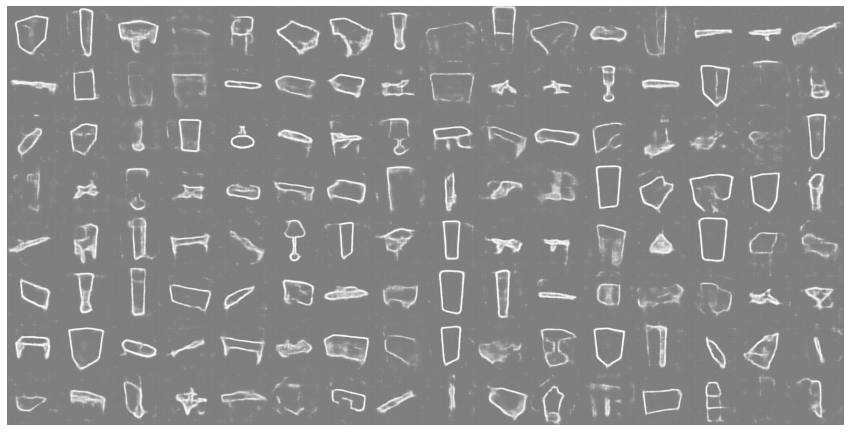

In [29]:
samples, _, _ = next(iter(loader_test))
samples = canny(samples.to(device))

print(f"Dimensions of a batch: {tuple(samples.shape)}")

reconstruction, _, _ = model(samples)

reconstruction = make_grid(reconstruction.cpu(), nrow=16, padding=0, 
                           normalize=False, range=None, 
                           scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(reconstruction)

### t-SNE Plot

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


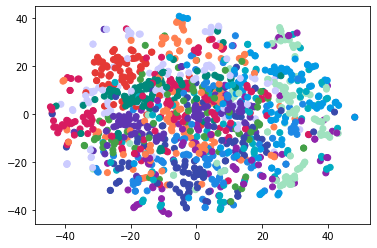

In [31]:
colours_lookup = {
    "02691156": "#E53935", # planes
    "02828884": "#D81B60", # benches
    "02933112": "#8E24AA", # cupboards/wardrobes
    "02958343": "#5E35B1", # cars
    "03001627": "#3949AB", # chairs
    "03211117": "#1E88E5", # computers
    "03636649": "#039BE5", # lamps
    "03691459": "#00ACC1", # speakers
    "04090263": "#00897B", # guns
    "04256520": "#43A047", # sofas
    "04379243": "#FF7F50", # tables/desks
    "04401088": "#9FE2BF", # phones
    "04530566": "#CCCCFF"  # boats
}

def get_colour(path):
    label = path.split("/")[1]
    return colours_lookup[label]

batches = list()
z_colours = list()

batch_iterable = iter(loader_test)

for _ in range(10):
    images, _, paths = next(batch_iterable)
    images = canny(images.to(device))
    mean, _ = model.encode(images)
    z = mean.cpu().detach().numpy()

    z_colours.extend(list(map(get_colour, paths)))

    batches.append(z)

z = np.vstack(tuple(batches))

z_reduced = TSNE(init="pca", learning_rate="auto").fit_transform(z)
z_reduced_x, z_reduced_y = zip(*z_reduced)

figure, axis = plt.subplots()

axis.scatter(list(z_reduced_x), list(z_reduced_y), c=z_colours)

## Query Test

### Create Embeddings Database

In [33]:
loader_database = DataLoader(db, batch_size=batch_size, shuffle=False)

embeddings_database = list()

for images, _, paths in tqdm.tqdm(loader_database, unit="batch"):
    images = canny(images.to(device))
    mu, _ = model.encode(images)
    embeddings = mu.cpu().detach().numpy()
    embeddings_database.extend(list(zip(embeddings, paths)))

  0%|          | 0/48 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 48/48 [00:06<00:00,  7.32batch/s]


In [34]:
test_embedding, test_path = embeddings_database[0]
print(test_embedding.shape, test_path)

(100,) ShapeNetReduced/04256520/2f87e4958b3c1d80b5da5256e41fa569/rendering/16.png


### Run Query

Similarity (closest image 1): 0.8372
Similarity (closest image 2): 0.7467
Similarity (closest image 3): 0.7175
Similarity (closest image 4): 0.6948
Similarity (closest image 5): 0.6654
Similarity (furthest image 1): -0.2938
Similarity (furthest image 2): -0.2967
Similarity (furthest image 3): -0.2999
Similarity (furthest image 4): -0.3215
Similarity (furthest image 5): -0.3791


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


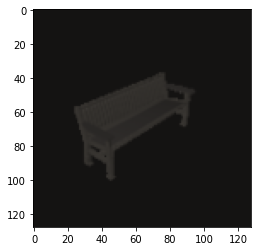

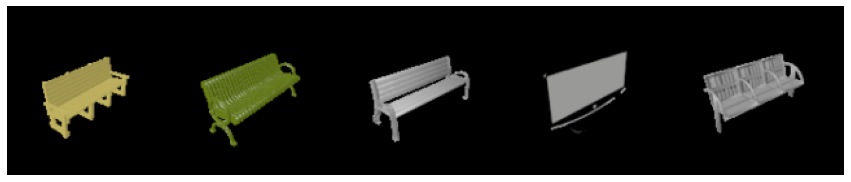

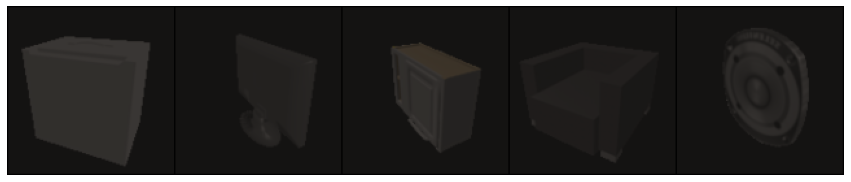

In [40]:
target, _, _ = random.choice(loader_query.dataset)
results = get_closest_match(target, embeddings_database)

figure, axis = plt.subplots()
show(target, axis=axis)

good_matches = list()

for i, (similarity, path) in enumerate(results[:5]):
    print(f"Similarity (closest image {i+1}): {similarity:.4f}")
    image = Image.open(path).convert("RGB")
    image = transform(image).unsqueeze(0)

    good_matches.append(image.cpu())

good_matches = torch.vstack(good_matches)
good_matches = make_grid(good_matches, nrow=5, padding=1, normalize=False,
                         range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(good_matches)

bad_matches = list()

for i, (similarity, path) in enumerate(results[-5:]):
    print(f"Similarity (furthest image {i+1}): {similarity:.4f}")
    image = Image.open(path).convert("RGB")
    image = transform(image).unsqueeze(0)

    bad_matches.append(image.cpu())

bad_matches = torch.vstack(bad_matches)
bad_matches = make_grid(bad_matches, nrow=5, padding=1, normalize=False,
                        range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(bad_matches)